In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/MyDrive/GSOC_code/updated_data/')



Mounted at /content/gdrive


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np

import os
import pickle
import random
from sklearn.utils import shuffle

from sklearn.model_selection import ParameterGrid

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Reshape, Concatenate)
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from keras import backend as BK

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers


# Table of contents
1. [Load custom functions](#customfunctions)
2. [Load data](#loaddata)
    <!-- 1. [Sub paragraph](#subparagraph1) -->
3. [Fit VAE model](#fitvae)

    3.1. [Define checkpoints](#checkpointsvae) 

    3.2. [Grid loop](#model_loop_vae) 

    3.3 [Model/grid specification](#grid_spec)

4. [Load saved VAE model](#loadvae)

4. [VAE model selection](#vaeselection) 

    4.1 [Load models (encoded space & losses)](#loadlatent)

    4.2 [Compare VAE models with different specifications](#vaecompare)

    4.3 [Compare loss of selected VAE and AE models](#vae_ae_compare)


5. [VAE latent space](#latentvae)

    5.1 [Latent space and impact parameter](#latentimpact)

    5.2 [Zero-impact spectra: Relating latent space and physical properties](#latentzeroimpact)








# Load custom functions <a name="customfunctions"></a>


In [ ]:
from model_functions import get_indep_normal_prior, get_prior_gauss_mixture, get_kl_regularizer, get_vae_encoder, get_vae_decoder, get_vae # VAE specific functions
from model_functions import custom_tanh, add_layer_to_list, get_checkpoint_callback # more general deep learning functions

In [ ]:
from analysis_functions import plot_pairplot, ols_backward_elimination
from analysis_functions import dump_object

from data_load_new import load_split_pool

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data <a name="loaddata"></a>


In [ ]:
# import data_load_colab
# from data_load_colab import *

directory_list = ['/content/gdrive/MyDrive/GSOC_code/updated_data/data_updated']
data_dict = load_split_pool(1929, "max", pooling_width = None, scale = False,
                    directory_list = directory_list)

Directory: /content/gdrive/MyDrive/GSOC_code/data_updated Physical properties shape: (2880, 17) Spectral prop shape: (2880, 119921)
Spectral data shape (2880, 119921)
Physical data shape (2880, 17)


In [ ]:
import tensorflow as tf

x_train = data_dict["x"]["train"].copy()
x_val = data_dict["x"]["val"].copy()


# Process the datasets

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, x_val))


train_dataset = train_dataset.shuffle(1000)

train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Fit VAE model  <a name="fitvae"></a>


## Define checkpoints  <a name="checkpointsvae"></a>


In [ ]:
# Define callbacks

# Define a call back for reduction in training rate on plateau
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=25,
    verbose=0,
    mode="auto",
    min_delta=0.0002,
    cooldown=0,
    min_lr=0,
)

# Define an early stopping callback
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

# Form callback list to be passed to .fit() method
callbacks = [earlystopping, reduce_learning_rate]

## Model/grid specification  <a name="grid_spec"></a>

In [ ]:
# from keras import backend as BK
max_val = data_dict['x']["train"].max().max()
# create custom tanh activation by specifying max value allowed for reconstructions
custom_tanh_activation = lambda x: custom_tanh(x, target_max=max_val)

# UNCOMMENT this if you want to checkpoint:
# checkpoint_filepath_dir = '/content/gdrive/MyDrive/GSOC_code/updated_data/outputs/vae'
prior_type = "gauss_mixture"  # "indep_normal"

epochs = 750

# penalty on KL divergence
weight_list = [1e-7]
# diemnsionality of the latent space
latent_dim = [4]
# specify hidden layers
hidden_units_layer1 = [256]
hidden_units_layer2 = [128]
hidden_units_layer3 = [None]

# For mparam grid
param_grid = {'latent_dim': latent_dim, 
              'hidden_units_layer1': hidden_units_layer1,
              'hidden_units_layer2': hidden_units_layer2,
              'hidden_units_layer3': hidden_units_layer3,
              'weight': weight_list}

pg_list = ParameterGrid(param_grid)

## Grid loop  <a name="model_loop_vae"></a>



In [ ]:
for model_spec in pg_list:

  # Re-set the weights to random
  BK.clear_session()  

  # Initialise file_name and dense layer list
  file_name = ( "latent_" + str(model_spec["latent_dim"]) +
               "_klweight_" + str(model_spec['weight']) )
  dense_layers = []

  # Append layers
  dense_layers, file_name = add_layer_to_list(dense_layers, file_name, model_spec["hidden_units_layer1"], activation = "relu")
  dense_layers, file_name = add_layer_to_list(dense_layers, file_name, model_spec["hidden_units_layer2"], activation = "relu")
  dense_layers, file_name = add_layer_to_list(dense_layers, file_name, model_spec["hidden_units_layer3"], activation = "relu")

  # Initialise and compile VAE model
  vae, _, _ = get_vae(x_train.shape, dense_layers, model_spec["latent_dim"], prior_type, model_spec["weight"], num_modes = 2, decoder_output_type = "distributions", 
                decoding_activation = custom_tanh_activation) 

  # Load checkpoint callback (if no filepath specified suppress error to allow for no checkpoint callback)
  try:
    checkpoint_callback, checkpoint_filepath = get_checkpoint_callback(checkpoint_filepath_dir, file_name)
    # UNCOMMENT this if you want to checkpoint:
    # callbacks.append(checkpoint_callback)
    print("File name:", file_name)
    print("Checkpoint path:", checkpoint_filepath)
  except:
    pass

  # Fit model with required callbacks
  vae_history = vae.fit(train_dataset, validation_data=test_dataset, epochs=epochs, 
                        callbacks = callbacks)


# Load saved VAE model  <a name="loadvae"></a>

In [ ]:
checkpoint_filepath_dir = '/content/gdrive/MyDrive/GSOC_code/updated_data/outputs/vae'

In [ ]:
max_val = data_dict['x']["train"].max().max()
# create custom tanh activation by specifying max value allowed for reconstructions
custom_tanh_activation = lambda x: custom_tanh(x, target_max=max_val)
prior_type = "gauss_mixture"  # "indep_normal"

epochs = 750

# penalty on KL divergence
weight_list = [1e-14]
# diemnsionality of the latent space
latent_dim = [4]
# specify hidden layers
hidden_units_layer1 = [256]
hidden_units_layer2 = [128]
hidden_units_layer3 = [None]



# For mparam grid
param_grid = {'latent_dim': latent_dim, 
              'hidden_units_layer1': hidden_units_layer1,
              'hidden_units_layer2': hidden_units_layer2,
              'hidden_units_layer3': hidden_units_layer3,
              'weight': weight_list}

pg_list = ParameterGrid(param_grid)

In [ ]:
results = dict()

for model_spec in pg_list:
  BK.clear_session()

  # Initialise file_name and dense layer list
  file_name = ( "latent_" + str(model_spec["latent_dim"]) +
               "_klweight_" + str(model_spec['weight']) )
  dense_layers = []

  # Append layers
  dense_layers, file_name = add_layer_to_list(dense_layers, file_name, model_spec["hidden_units_layer1"], activation = "relu")
  dense_layers, file_name = add_layer_to_list(dense_layers, file_name, model_spec["hidden_units_layer2"], activation = "relu")
  dense_layers, file_name = add_layer_to_list(dense_layers, file_name, model_spec["hidden_units_layer3"], activation = "relu")

  # Initialise and compile VAE model
  vae, encoder, decoder = get_vae(x_train.shape, dense_layers, model_spec["latent_dim"], prior_type, model_spec["weight"], num_modes = 2, decoder_output_type = "distributions", 
                decoding_activation = custom_tanh_activation) 
  
  # Load checkpoint callback
  checkpoint_callback, checkpoint_filepath = get_checkpoint_callback(checkpoint_filepath_dir, file_name)
  # print("Checkpoint path:", checkpoint_filepath)

  # if file does not exist, skip the load and print a message "failed to load"
  try:

      vae.load_weights(checkpoint_filepath)
      
      reconstr = vae.predict(x_val) # .mean()[:, 0, :] 
      reconstr_loss = (( reconstr.ravel() - x_val.ravel())**2 ).sum() /x_val.size

      # Save the model outputs and specification to dictionary
      results[file_name] = dict()

      results[file_name]["kl_weight"] = model_spec["weight"]
      results[file_name]["latent_dim"] = model_spec["latent_dim"]
      results[file_name]["model_spec"] = model_spec
      results[file_name]["loss"] = reconstr_loss

      results[file_name]["x_val_reconstruction"] = reconstr
      results[file_name]["x_val_encoded_mean"] =  encoder(x_val).mean().numpy()
      results[file_name]["x_val_encoded_sample"] =  encoder(x_val).sample().numpy()

      print(file_name, "loaded" )
      print("Loss:", reconstr_loss)
  except:
      print(file_name, "failed to load" )


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               30700032  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 14)                1806      
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  16        
Total params: 30,734,750
Trainable params: 30,734,750
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               640       
_________________

In [ ]:
# save results into a pickle file
# UNCOMMENT this if you want to overwrite results:
# dump_object(results, '/content/gdrive/MyDrive/GSOC_code/updated_data/outputs/vae', "results_vae")

NameError: ignored

# VAE model selection  <a name="vaeselection"></a>



## Load models (encoded space & losses)  <a name="loadlatent"></a>


In [ ]:
# Load VAE results
with open('/content/gdrive/MyDrive/GSOC_code/updated_data/outputs/vae/results_vae', 'rb') as f:
    dict_loaded_vae_encoded = pickle.load(f)

# Load autoencoder results
with open('/content/gdrive/MyDrive/GSOC_code/updated_data/outputs/ae/results_ae', 'rb') as f:
    dict_loaded_ae = pickle.load(f)

## Compare VAE models with different specifications   <a name="vaecompare"></a>


In [ ]:
# Form dataframe summarising, for each penalty parameter and each latent dimension:
# 1. Reconstruction loss of VAE
# 2. Log-likelihood of encoded latent space w.r.t. prior
# This will be later plotted using heatmaps 

kl_weight = list()
latent_dim = list()
loss_pd_grid = pd.DataFrame()
skew_pd_grid = pd.DataFrame()
kurt_pd_grid = pd.DataFrame()
log_prob_pd_grid = pd.DataFrame()

for model in dict_loaded_vae_encoded.keys():
  model_dict = dict_loaded_vae_encoded[model].copy()
  try:
    kl_weight.append(dict_loaded_vae_encoded[model]["kl_weight"])
    latent_dim.append(model_dict["latent_dim"])
    loss_pd_grid.loc[model_dict["kl_weight"], model_dict["latent_dim"]] = model_dict["loss"]
    skew_pd_grid.loc[model_dict["kl_weight"], model_dict["latent_dim"]] = np.abs( pd.DataFrame(model_dict["x_val_encoded_mean"]).skew() ).median()
    kurt_pd_grid.loc[model_dict["kl_weight"], model_dict["latent_dim"]] = np.abs( pd.DataFrame(model_dict["x_val_encoded_mean"]).kurtosis() ).median()
    kurt_pd_grid.loc[model_dict["kl_weight"], model_dict["latent_dim"]] = np.abs( pd.DataFrame(model_dict["x_val_encoded_mean"]).kurtosis() ).median()

    # Calculate log-likelihood (for an appropriate prior)
    prior = get_indep_normal_prior(model_dict["latent_dim"]) # equivalently: tfd.MultivariateNormalDiag( loc = tf.zeros(model_dict["latent_dim"]) )
    log_prob_pd_grid.loc[ model_dict["kl_weight"], model_dict["latent_dim"] ] = tf.reduce_sum( prior.log_prob(model_dict["x_val_encoded_mean"]) ).numpy()
  except:
    pass

In [ ]:
# Add AE to the summary dfs formed above


latent_dims_ae = list()
losses_ae = list()

# loop thorugh latent space dimensions which are stored in keys (as each dimension correpsonds to a different AE model)
for ae_model in dict_loaded_ae.keys():
  print(model)
  # reconstruction loss
  loss_pd_grid.loc["AE", dict_loaded_ae[ae_model]["latent_dim"]] = dict_loaded_ae[ae_model]["loss"]
  # log-likelihood
  prior = get_indep_normal_prior(dict_loaded_ae[ae_model]["latent_dim"])  # equivalently: tfd.MultivariateNormalDiag( loc = tf.zeros(dict_loaded_ae[ae_model]["latent_dim"]) )
  log_prob_pd_grid.loc[ "AE", dict_loaded_ae[ae_model]["latent_dim"] ] = tf.reduce_sum( prior.log_prob(dict_loaded_ae[ae_model]["x_val_encoded"]) ).numpy()

latent_10_dense1_256_dense2_128e_1e-06
latent_10_dense1_256_dense2_128e_1e-06
latent_10_dense1_256_dense2_128e_1e-06
latent_10_dense1_256_dense2_128e_1e-06
latent_10_dense1_256_dense2_128e_1e-06
latent_10_dense1_256_dense2_128e_1e-06
latent_10_dense1_256_dense2_128e_1e-06


In [ ]:
# Sort models for a nicer plot
sorted_model_index = ['AE', 1e-14, 1e-13, 1e-12, 1e-11, 1e-09, 1e-08, 1e-07, 1e-06,  0.0001]
sorted_dim_index = loss_pd_grid.columns.sort_values()

Text(0.5, 1.0, 'Log-likelihood (prior)')

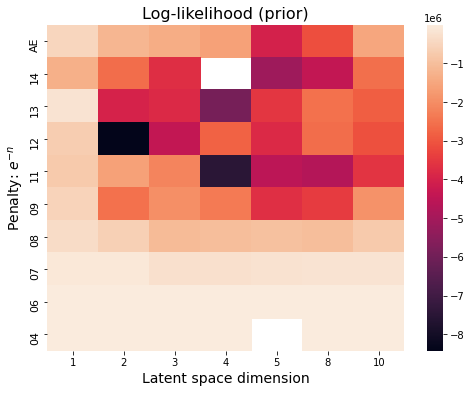

In [ ]:
# Plot log-likelihood w.r.t. prior
fig, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(log_prob_pd_grid.loc[sorted_model_index , sorted_dim_index])
ax.set_yticklabels(["AE", "14", "13", "12", "11", "09", "08", "07", "06",  "04"], fontsize = 11)
ax.set_ylabel("Penalty: $e^{-n}$", fontsize = 14)
ax.set_xlabel("Latent space dimension", fontsize = 14)
ax.set_title("Log-likelihood (prior)", fontsize = 16)

Text(0.5, 1.0, 'Reconstruction loss')

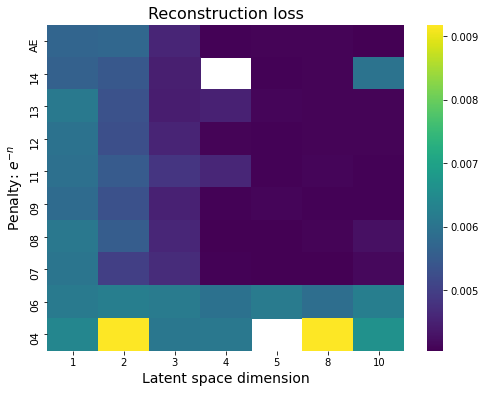

In [ ]:
# Plot reconstruction loss
fig, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(loss_pd_grid.loc[sorted_model_index , sorted_dim_index], cmap = sns.color_palette("viridis", as_cmap=True))
ax.set_yticklabels(["AE", "14", "13", "12", "11", "09", "08", "07", "06",  "04"], fontsize = 11)
ax.set_ylabel("Penalty: $e^{-n}$", fontsize = 14)
ax.set_xlabel("Latent space dimension", fontsize = 14)
ax.set_title("Reconstruction loss", fontsize = 16)

## Compare loss of selected VAE and AE models <a name="vae_ae_compare"></a>


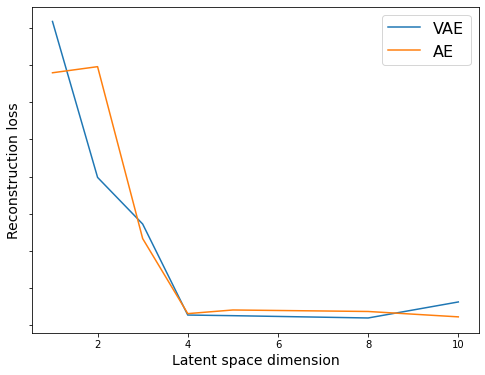

In [ ]:
# As the best VAE model seems to be one with penaly 1e-07, compare it's reconstruction loss to that of AE for different latent space dimensions

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(np.array([1,2,3,4,5,8,10]), loss_pd_grid.loc[1e-07, [1,2,3,4,5,8,10]], label = "VAE")
ax.plot(np.array([1,2,3,4,5,8,10]), loss_pd_grid.loc["AE", [1,2,3,4,5,8,10]], label = "AE")
# loss_pd_grid.loc[1e-07, :]
ax.set_xlabel("Latent space dimension", fontsize = 14)
ax.set_ylabel("Reconstruction loss", fontsize = 14)
ax.set_yticklabels([])
ax.legend(fontsize = 16)

# VAE latent space <a name="latentvae"></a>

## Latent space and impact parameter <a name="latentimpact"></a>


In [ ]:
# Load phyical properties
y_train_df = pd.DataFrame(data_dict["y"]["train"], columns = data_dict['physical_col_names'])

# calculate angle differences
y_train_df["angle_diff1"] = y_train_df['halo_unit_vector1'] - y_train_df['ray_unit_vector1']
y_train_df["angle_diff2"] = y_train_df['halo_unit_vector2'] - y_train_df['ray_unit_vector2']

# drop the ones that are less useful
y_train_df.drop(['bad_trajectories', 'zero_length', 'ray_number', 'halo_unit_vector1',
       'halo_unit_vector2', 'halo_unit_vector3', 'ray_unit_vector1',
       'ray_unit_vector2', 'ray_unit_vector3'], axis = 1, inplace = True)

# Do the same for validation data
y_val_df = pd.DataFrame(data_dict["y"]["val"], columns = data_dict['physical_col_names'])

y_val_df["angle_diff1"] = y_val_df['halo_unit_vector1'] - y_val_df['ray_unit_vector1']
y_val_df["angle_diff2"] = y_val_df['halo_unit_vector2'] - y_val_df['ray_unit_vector2']

y_val_df.drop(['bad_trajectories', 'zero_length', 'ray_number', 'halo_unit_vector1',
       'halo_unit_vector2', 'halo_unit_vector3', 'ray_unit_vector1',
       'ray_unit_vector2', 'ray_unit_vector3'], axis = 1, inplace = True)


In [ ]:
# Load encoded spectra for the selected model:
x_val_encoded_vae = pd.DataFrame( dict_loaded_vae_encoded['latent_4_dense1_256_dense2_128e_1e-07']["x_val_encoded_mean"] )

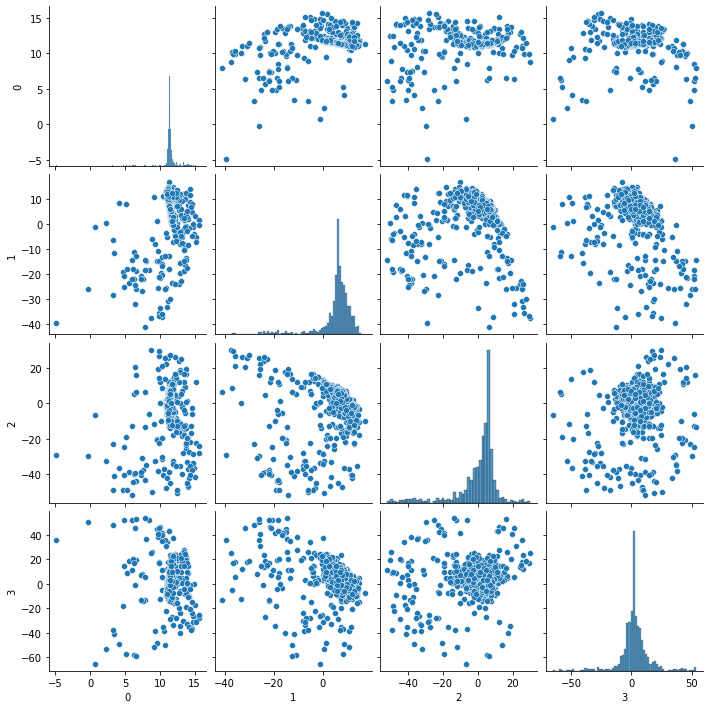

In [ ]:
# Plot the encoded space (spectra) of the selected model
sns.pairplot(x_val_encoded_vae)

In [ ]:
# Plot encoded spectra, colored by the impact parameter

# merge encoded spectra and physical variables (for easier plotting)
merged_encoded_phys_vae = pd.merge(  x_val_encoded_vae, y_val_df, left_index = True, right_index = True)
# create binary variable indicating zero impact_parameter
merged_encoded_phys_vae["zero_impact"] = merged_encoded_phys_vae["impact_param"] == 0
# Plot encoded spectra, coloured by the "zer_impact" variable
sns.pairplot(merged_encoded_phys_vae, vars = [0, 1, 2, 3], hue = "zero_impact", palette = "viridis")

In [ ]:
# create two datasets: one containing only zero-impact encoded spectra, the other containing only non-zero impact encoded specta
merged_encoded_phys_vae_zero_impact = merged_encoded_phys_vae[merged_encoded_phys_vae["impact_param"] == 0]
merged_encoded_phys_vae_nonzero_impact = merged_encoded_phys_vae[merged_encoded_phys_vae["impact_param"] != 0]

# Plot non-zero impact encoded spectra, colored by the impact parameter (this time colored continuously)
vars = [0, 1, 2, 3]

plot_pairplot(df =  merged_encoded_phys_vae_nonzero_impact, vars = vars, hue_var = "impact_param", cmap_scheme = "Blues", scatter_colour = "steelblue");

## Zero-impact spectra: Relating latent space and physical properties <a name="latentzeroimpact"></a>

Next we look at how latent space of zero-impact spectra is realted to physical properties. This is generally hard to spot in plots so we proceed as follows:
1. For a given latent feature, regress it on physical features, their interactions and squares. 
2. Use backward search to find the most important explanatory variable(s). Namely, successively eliminate variables from the model, such that at each step, variable whose elimination produces the smallest drop in R-squared is eliminated.
3. Plot the relationships found by the model.

In [ ]:
# Relating physical parameters and latent space for Zero-impact spectra

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

poly = PolynomialFeatures(interaction_only=False, include_bias = False)

# select latent feature
# latent_feature = 0


dict_elimination_nonzero_impact_ae = dict()

# Physical properties of interest
X_input = merged_encoded_phys_vae_zero_impact.loc[:, ['impact_param', 'r_v', 'stellar_radius', 'circularity', 'angle_diff1', 'angle_diff2']]
# Add interactions and squares of all variables
X_interactions = poly.fit_transform(X_input)
# get names of new variables for better interpretability
interaction_names = poly.get_feature_names(X_input.columns)
# Form an extended dataframe
X_interactions_df = pd.DataFrame(X_interactions, columns = interaction_names)


In [ ]:
# Dictionary to store results
dict_elimination_nonzero_impact_ae = dict()
# Loop through latent features
for i in range(4):

  dict_elimination_nonzero_impact_ae[str(i)] = dict() # initialise sub-dict. 
  # latent feature:
  Y = merged_encoded_phys_vae_zero_impact.iloc[:,i].copy()
  Y = np.array(Y).reshape(-1,1)
  # explanatory variables (physical properties + their interactions + their squares)
  X = X_interactions_df.copy() 
  scaler_x = StandardScaler()
  # scale the variables (standardisations only changes coefficients, but makes interpretability easier)
  X_scaled = scaler_x.fit_transform(X)

  # Backward elimination to find the most important features
  r, f, r2_adj = ols_backward_elimination(Y, X = X_scaled, X_columns = X_interactions_df.columns)
  # store results
  dict_elimination_nonzero_impact_ae[str(i)]["r_squared"] = r
  dict_elimination_nonzero_impact_ae[str(i)]["features"] = f  
  dict_elimination_nonzero_impact_ae[str(i)]["r_asquared_adj"] = r2_adj 

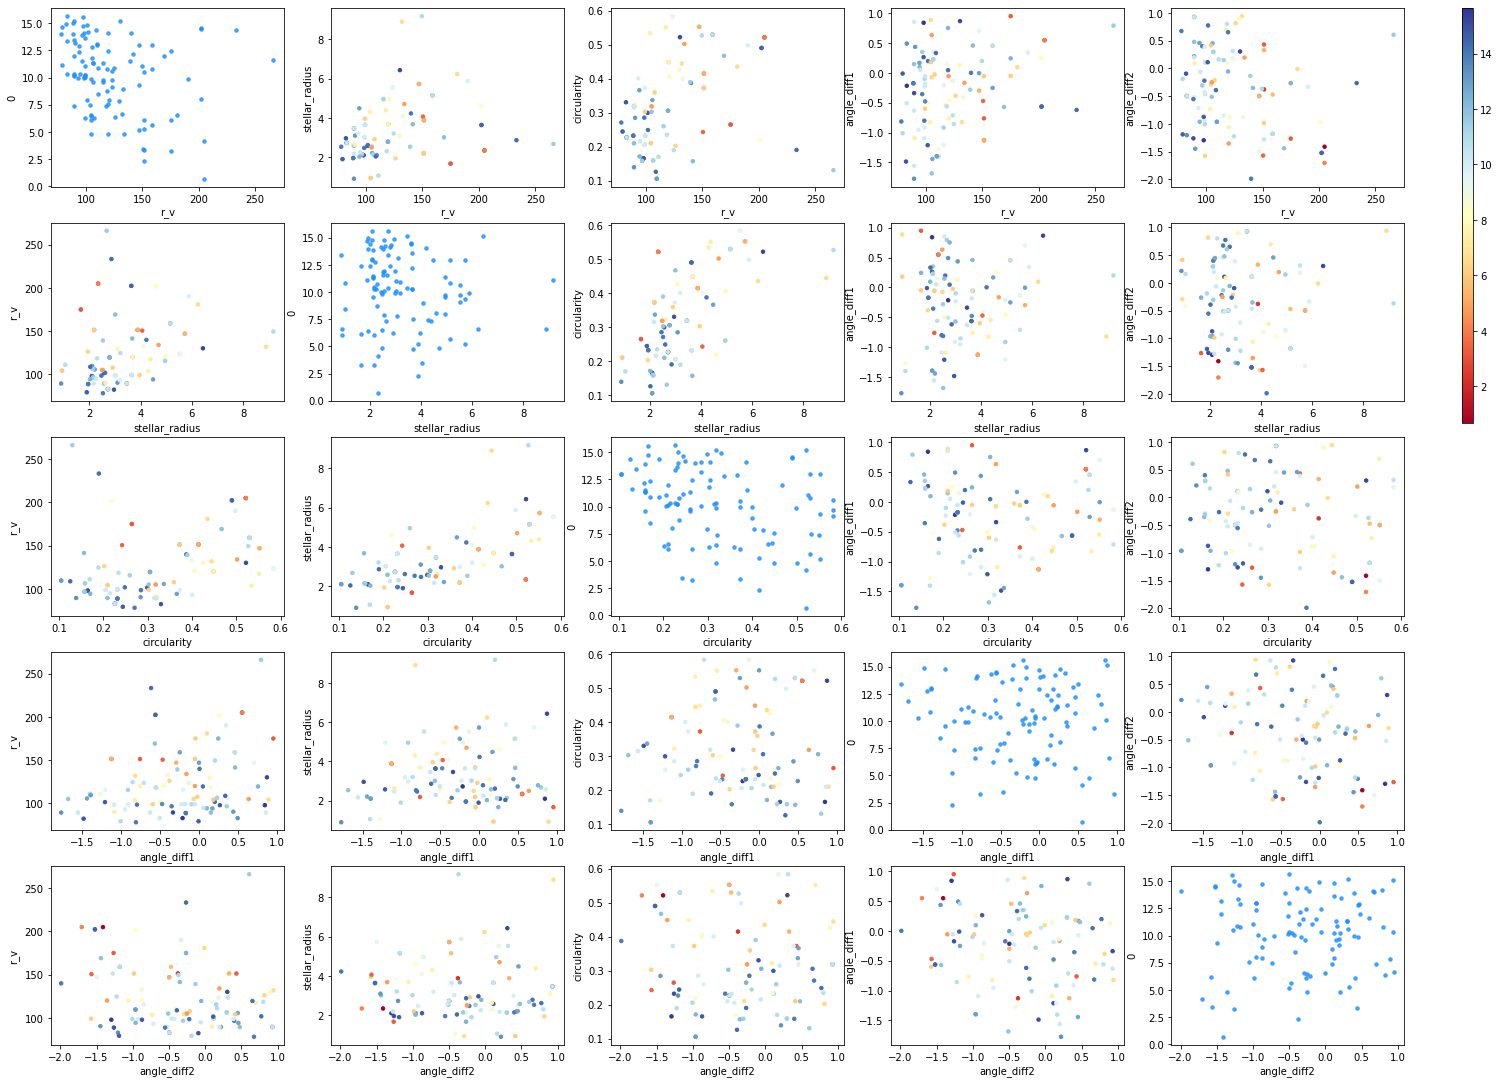

In [ ]:
vars = ['r_v', 'stellar_radius', 'circularity', "angle_diff1", "angle_diff2"]

plot_pairplot(df =  merged_encoded_phys_vae_zero_impact.loc[merged_encoded_phys_vae_zero_impact[0] > 0, :], 
              vars = vars, hue_var = 0, cmap_scheme = "RdYlBu", log = False);

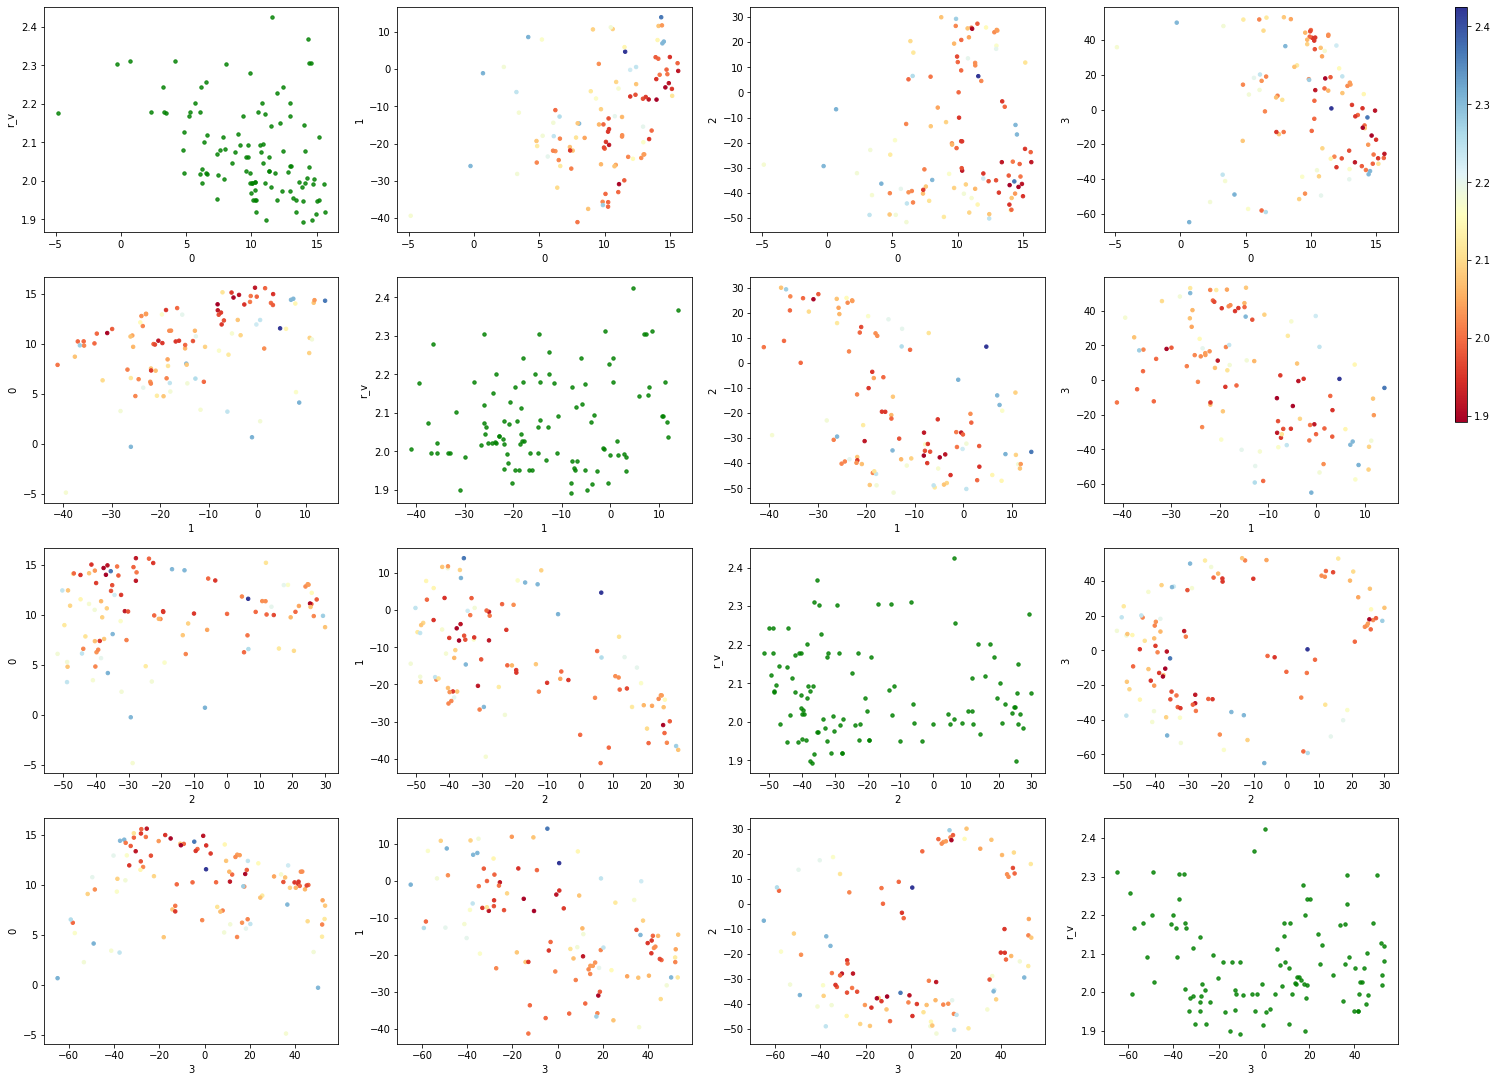

In [ ]:
# We can reverse the logic: plot scatters of latent fieatures, and color byphysical features

# here plot virial radius (in color) as a function of latent variables (on x and y axis)
hue_var = "r_v"
hue_series = merged_encoded_phys_vae_zero_impact.loc[:,hue_var]
cmap_scheme = "Greens"

vars = [0, 1, 2, 3]

plot_pairplot(df =  merged_encoded_phys_vae_zero_impact, 
              vars = vars, hue_var = "r_v", cmap_scheme = "RdYlBu", scatter_colour = "Green", log = True);

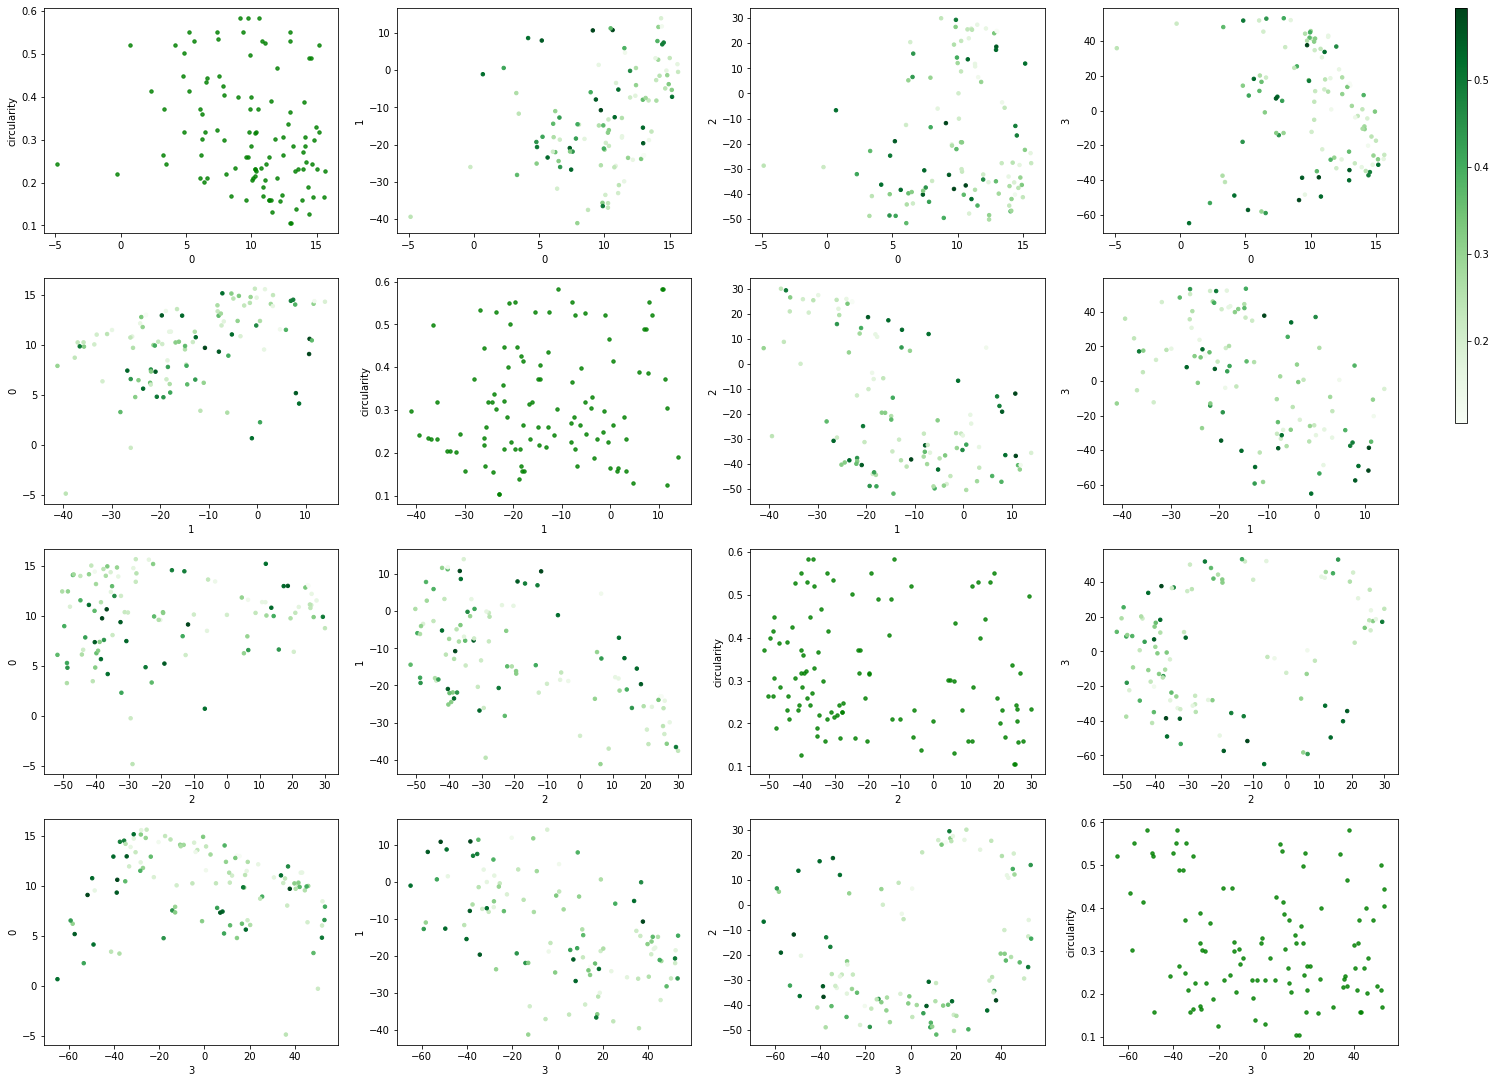

In [ ]:
# Do the same for circularity
hue_var = "circularity"
hue_series = merged_encoded_phys_vae_zero_impact.loc[:,hue_var]
cmap_scheme = "Greens"

vars = [0, 1, 2, 3]

plot_pairplot(df =  merged_encoded_phys_vae_zero_impact, vars = vars, hue_var = hue_var, cmap_scheme = "Greens", scatter_colour = "Green");